In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [15]:
graduses = pd.read_csv('data/Offset equipment temperature degrees Celsius observed every 10 minutes.csv')

df = graduses.sort_index()

### Скользящее среднее

In [16]:
df['MA_window_3'] = df["temperature"].rolling(window=3).mean()
df

,Unnamed: 0,temperature,MA_window_3
0,1,22.0,NaN
1,2,22.8,NaN
2,3,22.9,22.566667
3,4,22.5,22.733333
4,5,22.5,22.633333
...,...,...,...
4320,4321,32.7,32.100000
4321,4322,32.5,32.466667
4322,4323,32.5,32.566667
4323,4324,32.0,32.333333


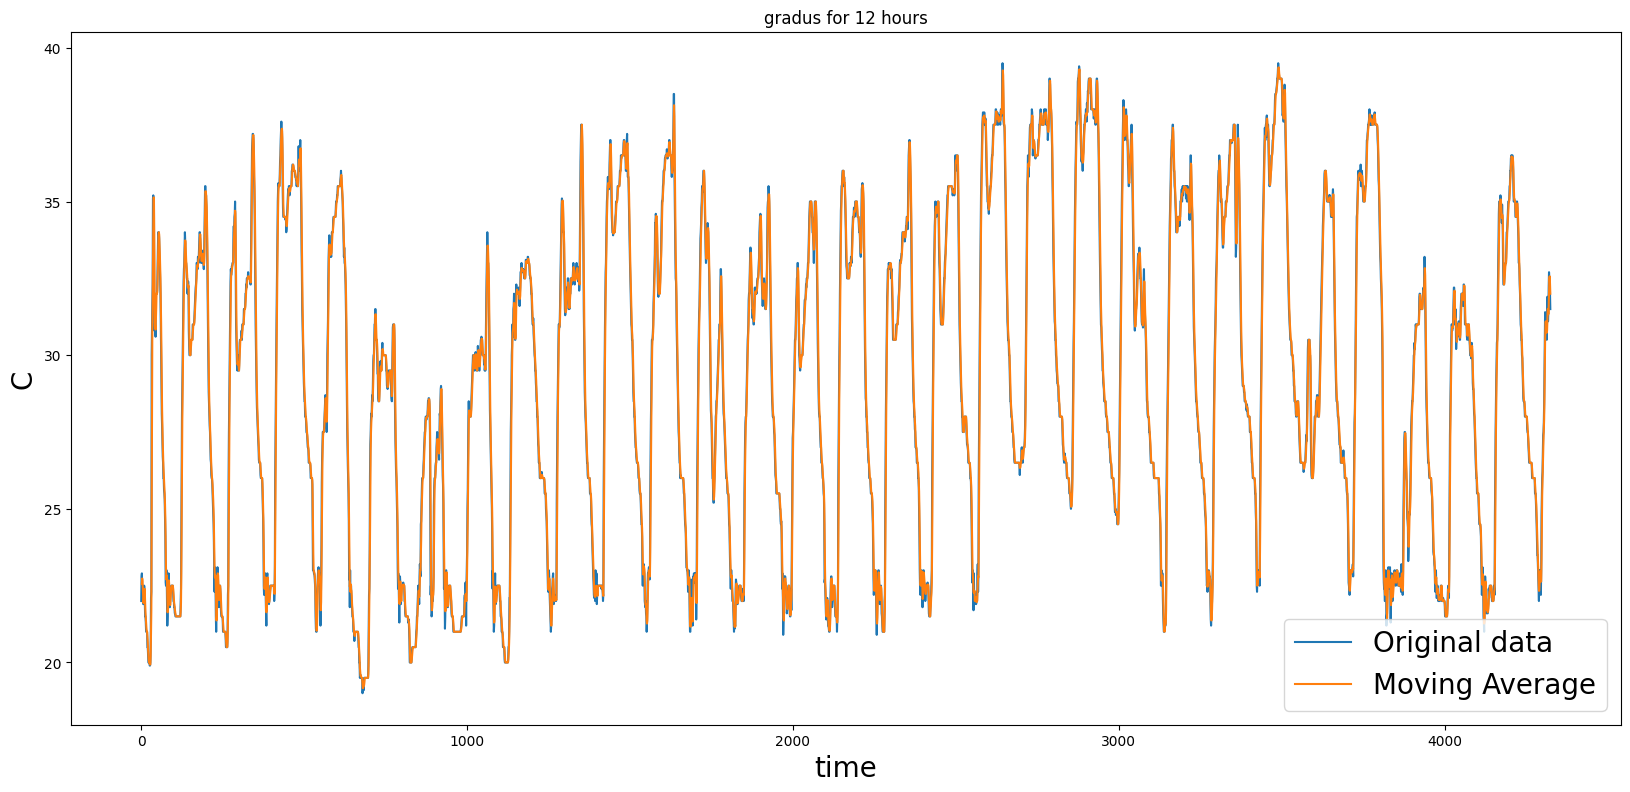

In [18]:
fig = plt.figure(figsize=(20, 9))
plt.plot(df["temperature"], label='Original data')
plt.plot(df['MA_window_3'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

Можно поиграться с размерностью окна

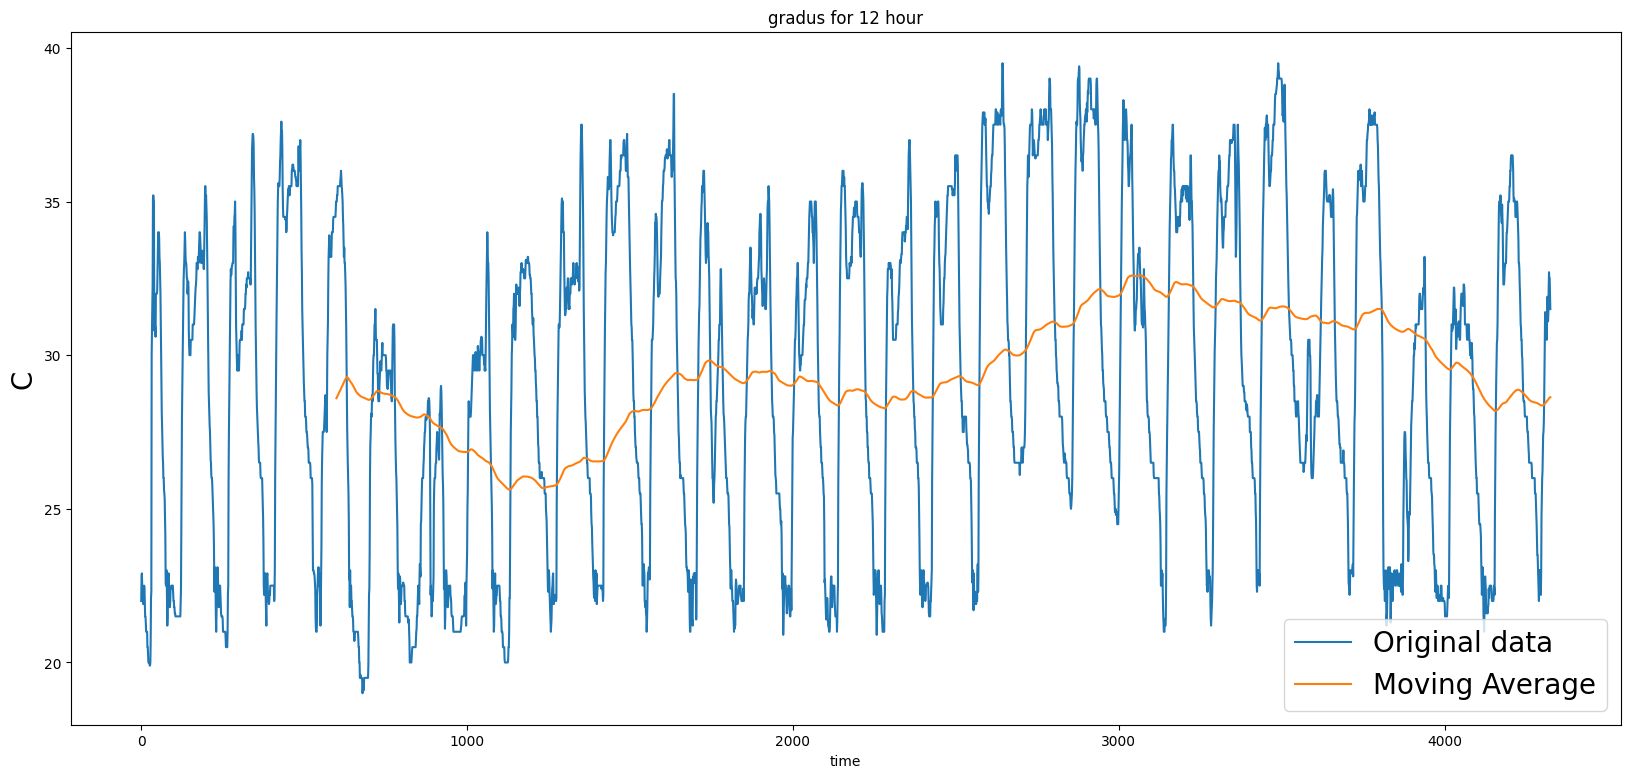

In [20]:
df['MA_window_6'] = df["temperature"].rolling(window=600).mean()
fig = plt.figure(figsize=(20, 9))
plt.plot(df["temperature"], label='Original data')
plt.plot(df['MA_window_6'], label='Moving Average')
plt.legend(fontsize="20")
plt.title('gradus for 12 hour')
plt.ylabel('C', fontsize="20")
plt.xlabel('time')
plt.show()


Функцию, которая поможет понять тенденцию и движения временного ряда. Некоторая скользящая статистику, такая как:

M скользящее среднее: невзвешенное среднее предыдущих n данных (также называемое скользящим средним).

Полосы Боллинджера: верхняя полоса в k раз на n -периодное стандартное отклонение выше скользящей средней и нижняя полоса в k раз на стандартное отклонение N ниже.

In [21]:
'''
Отрисовка скользящего среднего по медиане для ts с 95% доверительным интервалом для стандартного отклонения.
:parameter
  :param ts: датасет
  :param window: кол-во семплов в окне - для скользящих средних
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=100,
            figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='Реальные значения', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
                 color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                     color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\3736708662.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


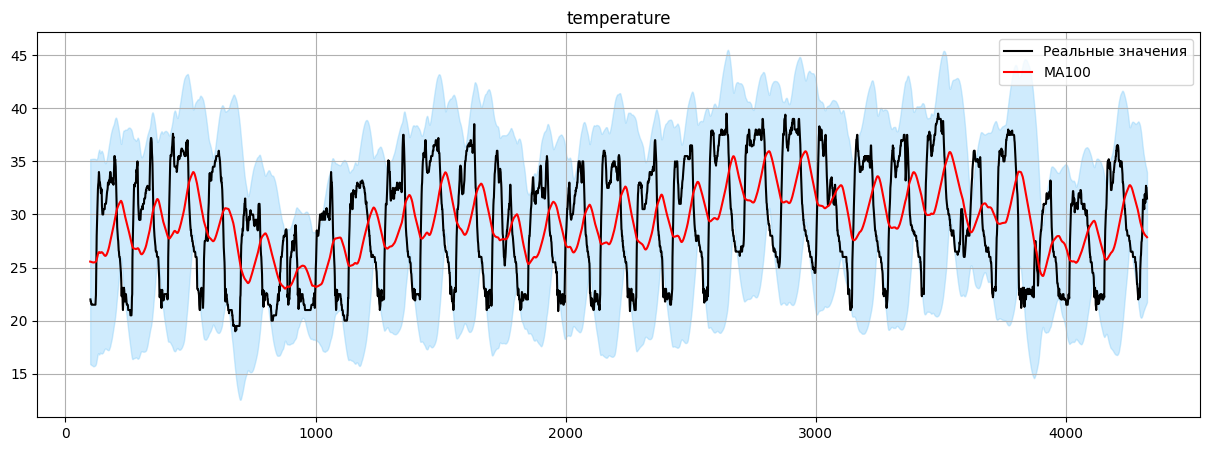

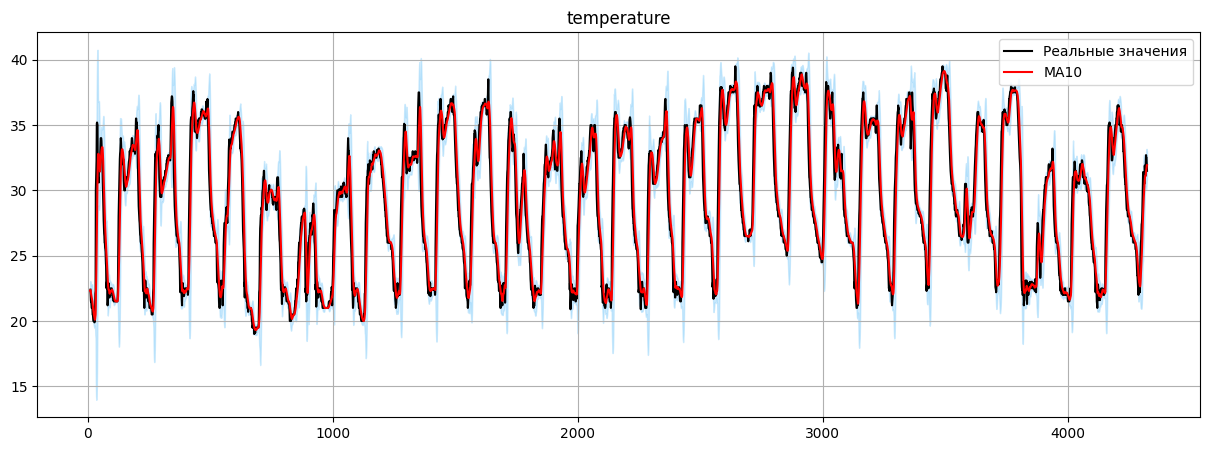

In [22]:
plot_ts(df["temperature"], window=100)
plot_ts(df["temperature"], window=10)

### ARMA

In [23]:
from statsmodels.tsa.arima.model import ARIMA

## Предсказание ряда на основе предыдущих значений

### ARIMA  

Модель авторегрессии скользящего среднего и систематический подход к её построению предназначена для анализа стационарных временных рядов на основе оценки линейной зависимости прогнозируемых значений от исторических.

Для использования модели временной ряд должен быть стационарным, т.е. его среднее и дисперсия должны быть постоянны.

Модель Бокса-Дженкинса предполагает, что временной ряд содержит три составляющие: авторегресионную, интегрированную и скользящее среднее, которые в модели обозначены $p$, $d$ и $q$ соответственно:

* Величина $p$ называется порядком авторегрессии. Она позволяет ответить на вопрос, будет ли очередной элемент ряда близок к значению $X$, если к нему были близки $p$ предыдущих значений.
* Величину $d$ называют порядком интегрирования. Она показывает, насколько элемент ряда близок по значению к $d$ предыдущим значениям, если разность между ними минимальна.

* Параметр $q$— порядок скользящего среднего. Позволяет установить погрешность модели как линейную комбинацию наблюдавшихся ранее значений ошибок.

Авторегрессия — это составляющая модели временного ряда, в которой его прогнозируемое значение может быть выражено в виде линейной комбинации исторических значений этого же ряда и случайной ошибки.

Обычно модель упоминается, как ARIMA$(p,d,q)$, где $p$, $d$ и $q$ — целые неотрицательные числа, характеризующие порядок для частей модели (соответственно авторегрессионной, интегрированной и скользящего среднего).

Для временного ряда $X(t)$ модель может быть записана в виде:

$$(\delta^dX_t)=\sum^p_{t=1}a_t(\delta^dX_{t-1}) + \epsilon_t + \sum^q_{j=1}b_j(\delta^d\epsilon_{t-j})$$

где

* $\delta^d$ — оператор разности порядка $d$ (последовательное взятие $d$ раз разностей первого порядка — сначала от самого ряда, затем от полученных разностей первого порядка, затем от второго порядка и т. д.);
* $a_t$— коэффициенты авторегрессионной части модели, $\epsilon_t$— значения ошибки (полагаются независимыми одинаково распределёнными случайными величинами из нормального распределения с нулевым средним);
* $b_j$ — коэффициенты скользящего среднего.

Модель Бокса-Дженкинса широко применяются при прогнозировании временных рядов. Основная задача при этом заключается в оценке параметров модели. Методология построения ARIMA-модели исследуемого временного ряда включает следующие основные этапы:

* построение пробной модели;
* оценивание параметров модели и проверка адекватности модели;
* использование модели для прогнозирования.

Чтобы построить модель ARMA, мы можем использовать функцию ARIMA (которая будет
объяснена в следующем разделе) в statsmodels.tsa.arima.model и указать
гиперпараметр — order(p, d, q). Когда d = 0, он работает как модель ARMA.

In [24]:
arma_model = ARIMA(df["temperature"], order=(5,0,3))
arma_model_fit = arma_model.fit()

c:\Users\vegam\Documents\Для Временных Рядов\my_venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\vegam\Documents\Для Временных Рядов\my_venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\vegam\Documents\Для Временных Рядов\my_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
print(arma_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 4325
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -2298.123
Date:                Sat, 21 Oct 2023   AIC                           4616.247
Time:                        14:01:03   BIC                           4679.969
Sample:                             0   HQIC                          4638.745
                               - 4325                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.1702      0.662     44.070      0.000      27.873      30.467
ar.L1          0.8432      0.051     16.485      0.000       0.743       0.943
ar.L2          0.2644      0.061      4.350      0.0

In [26]:
X = df["temperature"].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [27]:
print(len(train))
print(len(test))
print(len(arma_predictions))

2854
1471
1471


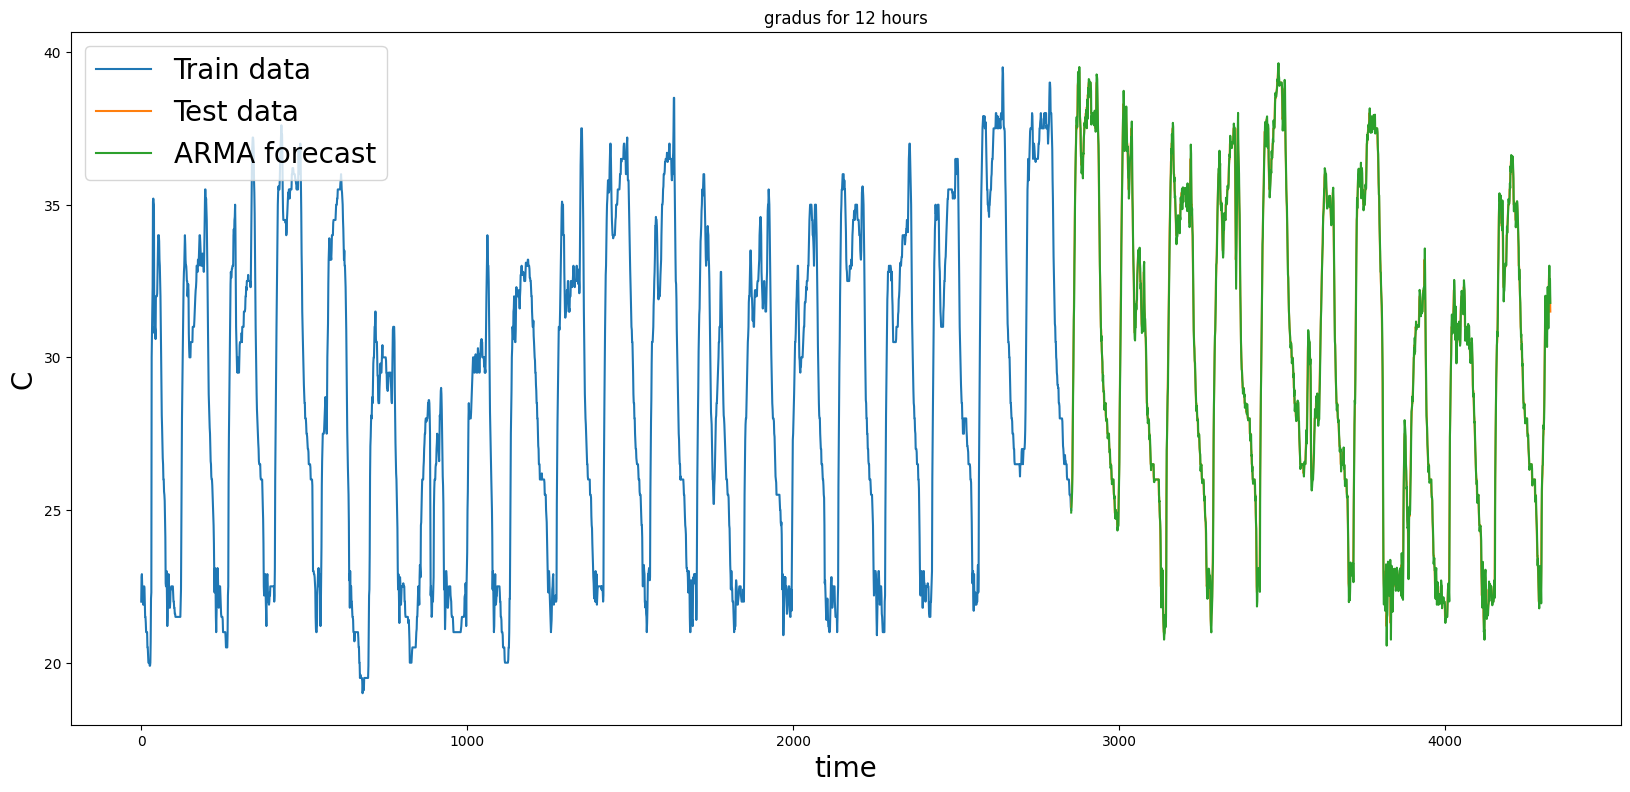

In [28]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(0, size)], train, label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

### Работа с пропусками данных

Заполнение средним и медианой

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\4076821353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["temperature"][1000:1200] = np.nan


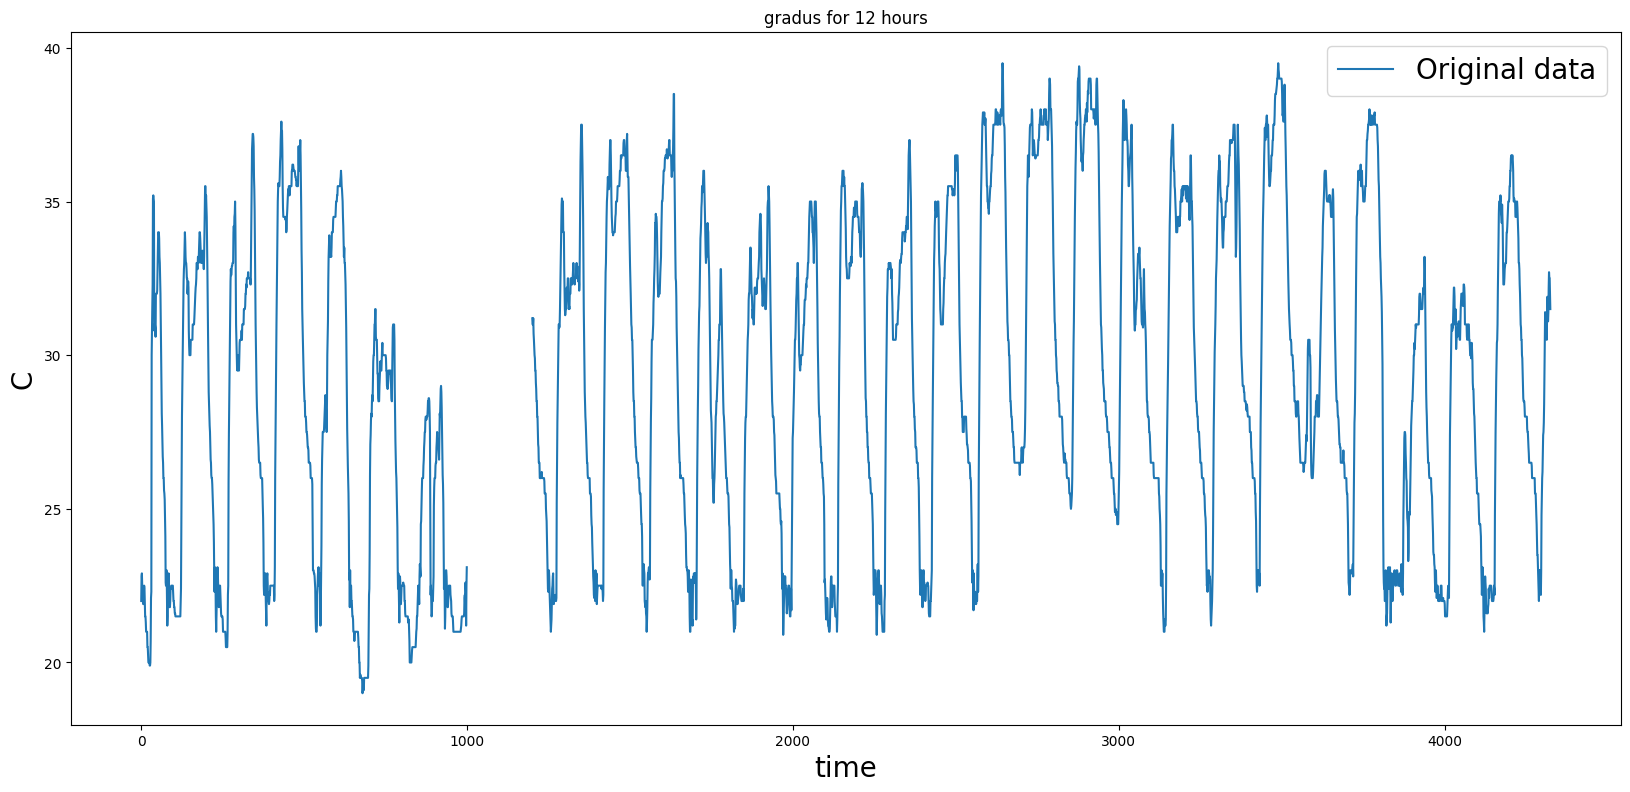

In [37]:
o_df = df.copy()

o_df = graduses.sort_index()

o_df["temperature"][1000:1200] = np.nan

fig = plt.figure(figsize=(20, 9))
plt.plot(o_df["temperature"], label='Original data')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\1520193468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["temperature"][1000:1200] = new_value


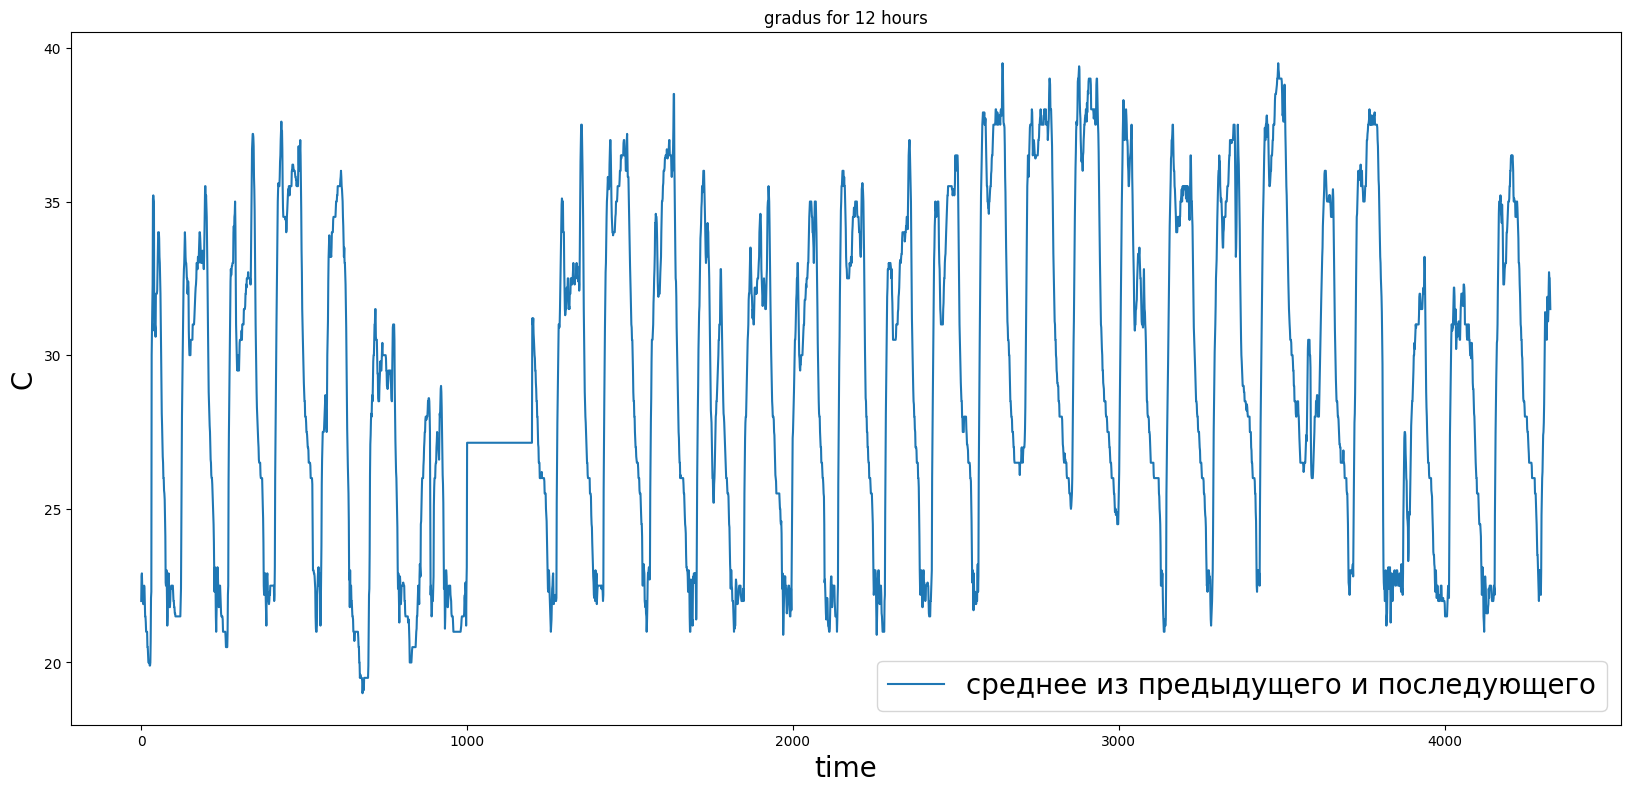

In [38]:
new_value = (o_df["temperature"][1200] + o_df["temperature"][999])/2

o_df["temperature"][1000:1200] = new_value

fig = plt.figure(figsize=(20, 9))
plt.plot(o_df["temperature"], label='среднее из предыдущего и последующего')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

Заполнение предыдущим и последующим значениями​

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\3830127601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["temperature"][1000:1200] = new_value


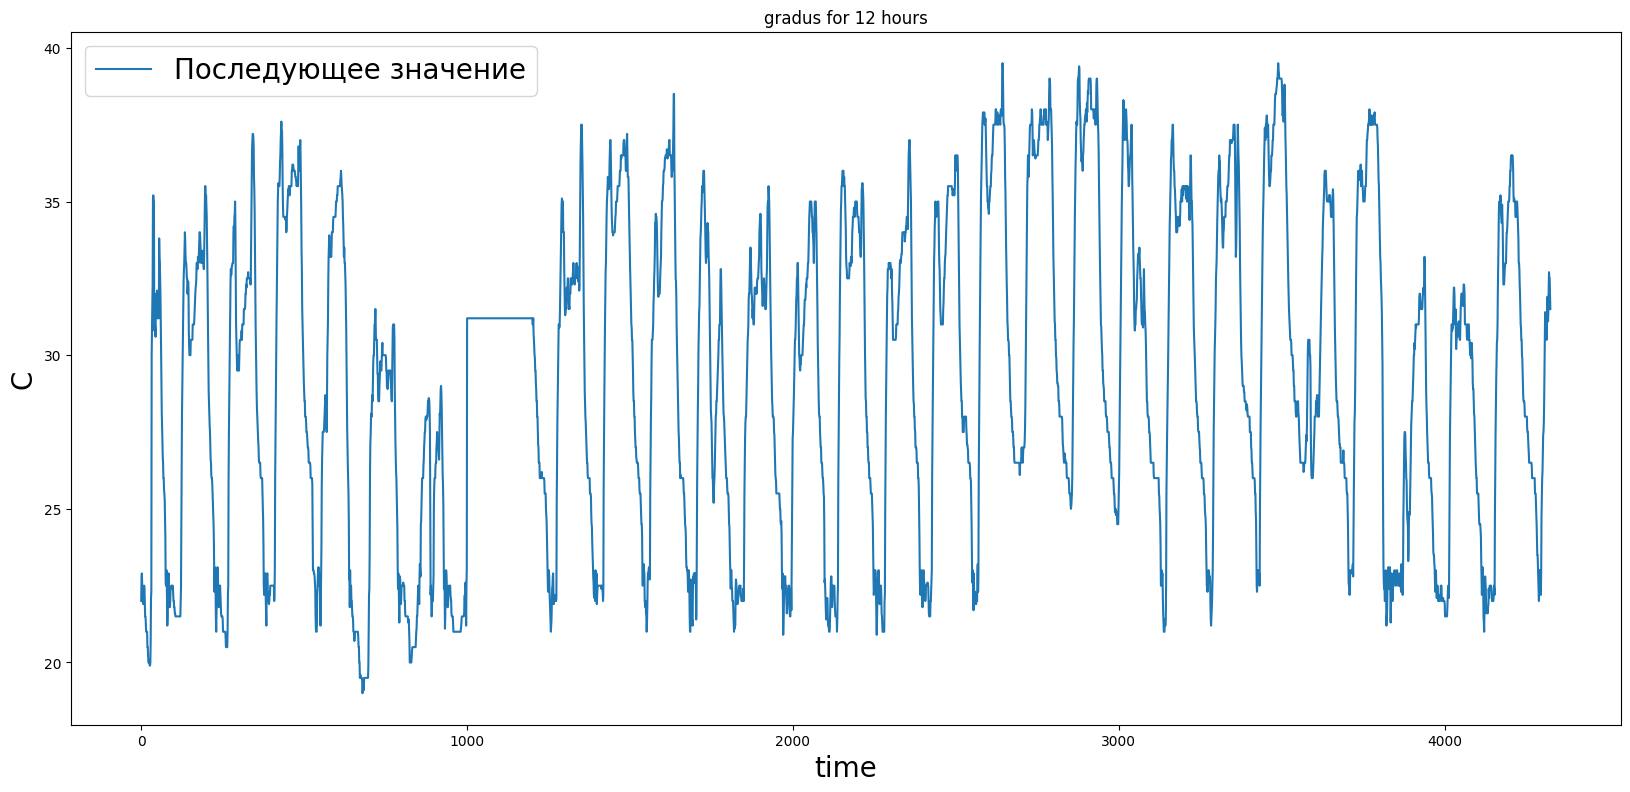

In [42]:
new_value = o_df["temperature"][1200]

o_df["temperature"][1000:1200] = new_value

fig = plt.figure(figsize=(20, 9))
plt.plot(o_df["temperature"], label='Последующее значение')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\296846963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["temperature"][1000:1200] = new_value


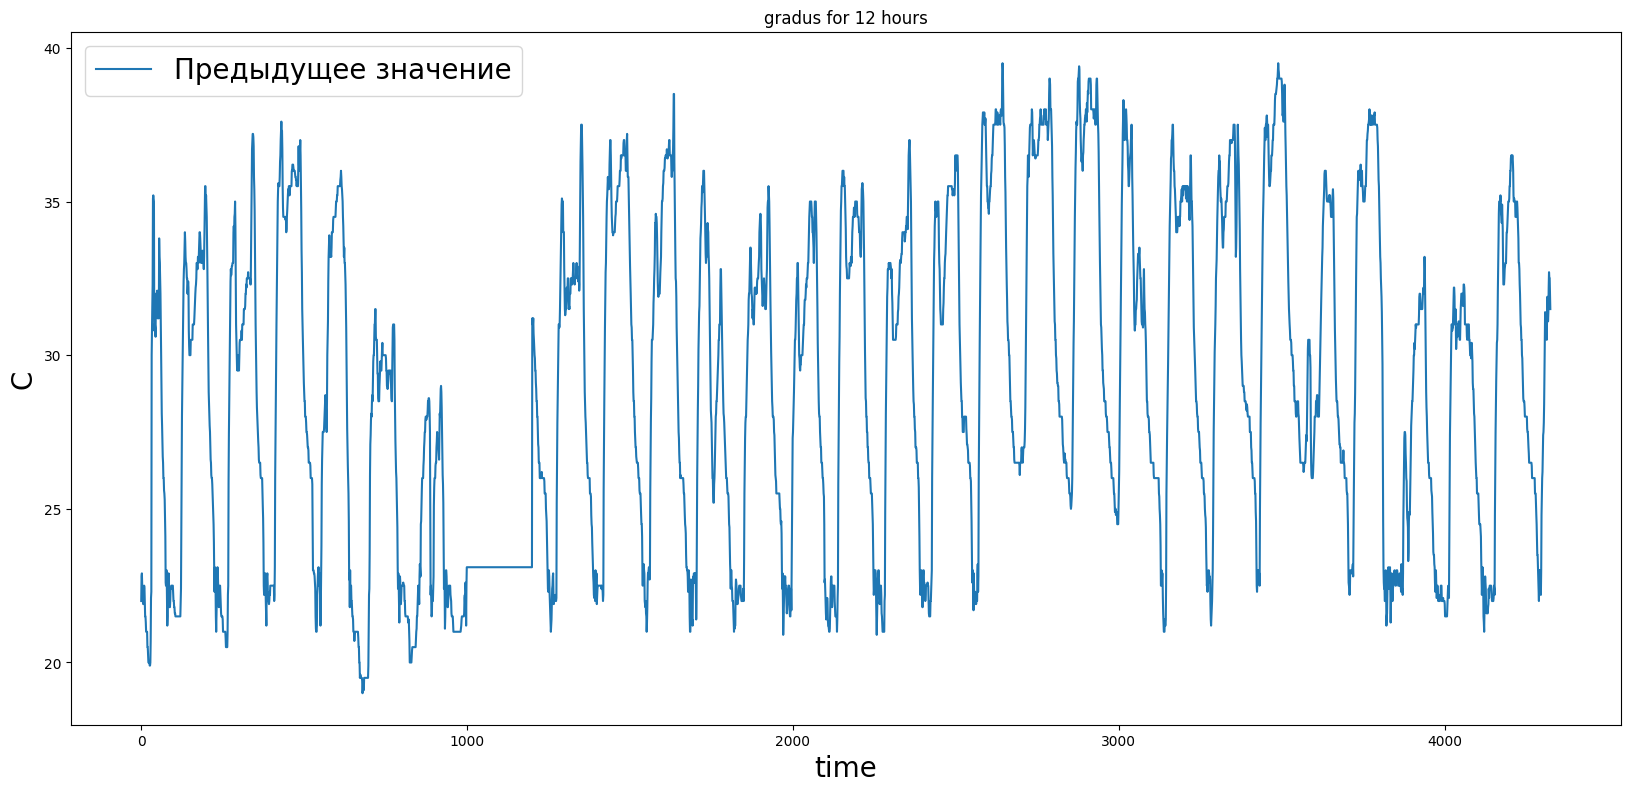

In [43]:
new_value = o_df["temperature"][999]

o_df["temperature"][1000:1200] = new_value

fig = plt.figure(figsize=(20, 9))
plt.plot(o_df["temperature"], label='Предыдущее значение')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

Заполнение скользящим средним и медианой​

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\2863310826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["temperature"][1000:1200] = new_value


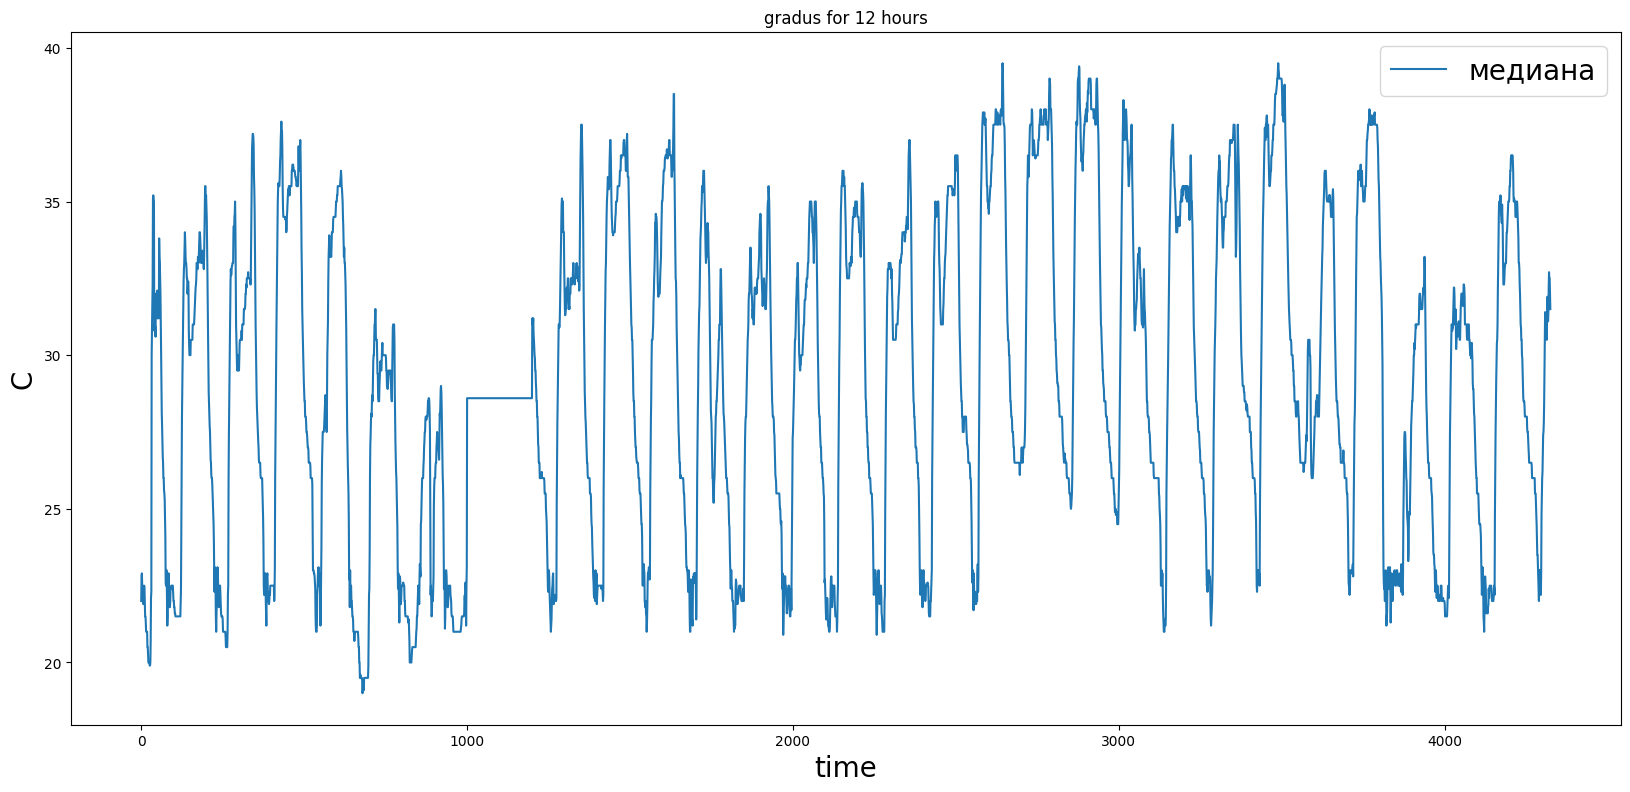

In [44]:
new_value = o_df["temperature"].median()

o_df["temperature"][1000:1200] = new_value

fig = plt.figure(figsize=(20, 9))
plt.plot(o_df["temperature"], label='медиана')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\1034943559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["temperature"][1000:1200] = new_value


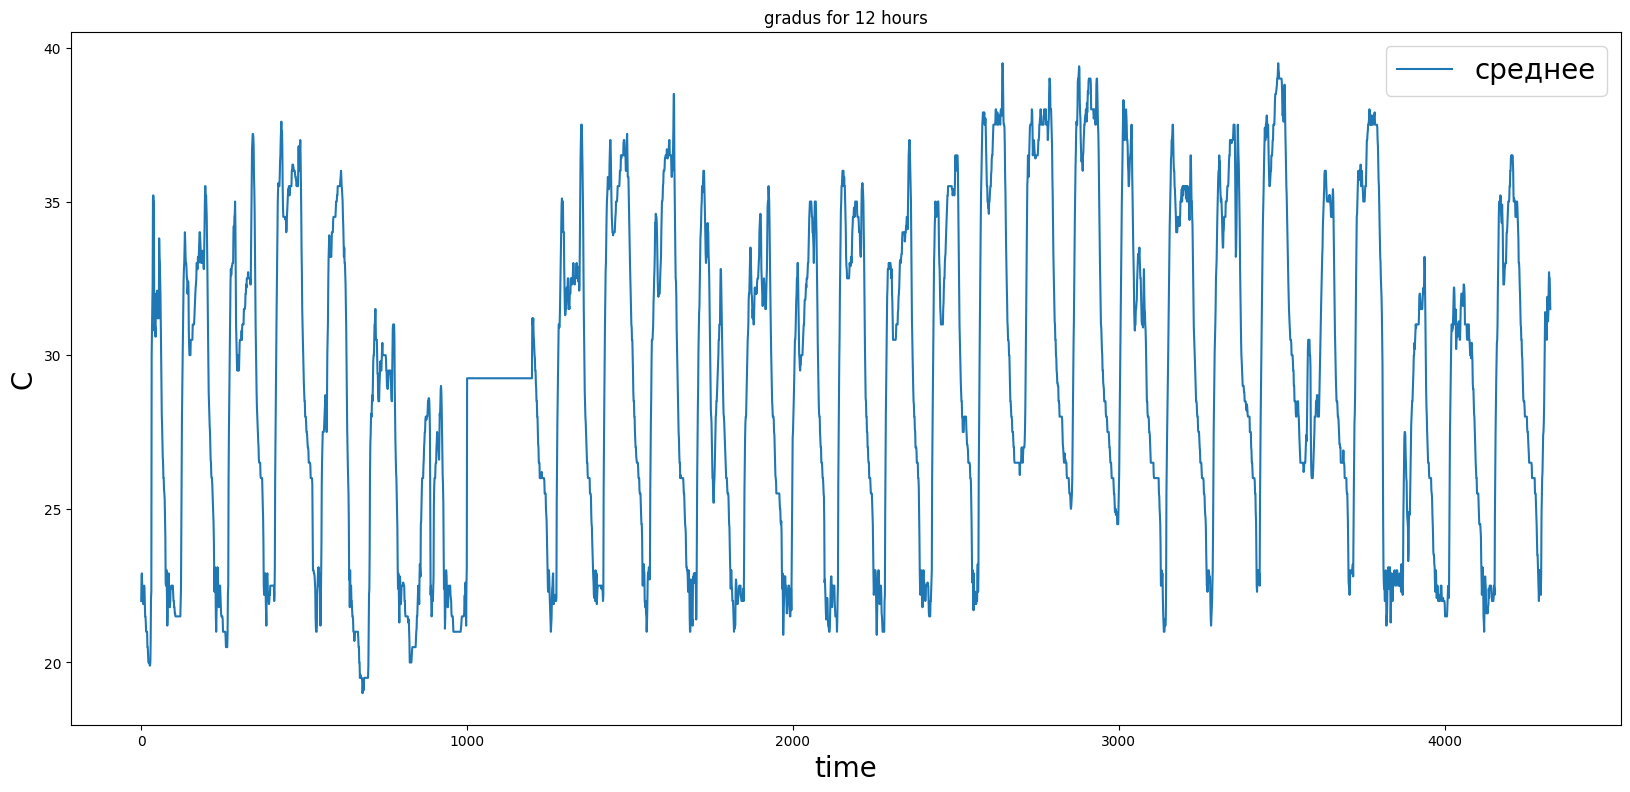

In [45]:
new_value = o_df["temperature"].mean()

o_df["temperature"][1000:1200] = new_value

fig = plt.figure(figsize=(20, 9))
plt.plot(o_df["temperature"], label='среднее')
plt.legend(fontsize="20")
plt.title('gradus for 12 hours')
plt.ylabel('C', fontsize="20")
plt.xlabel('time', fontsize="20")
plt.show()

Интерполяция

C:\Users\vegam\AppData\Local\Temp\ipykernel_7888\3373062340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o_df["temperature"][1000:1200] = np.nan


<Axes: title={'center': 'zero'}>

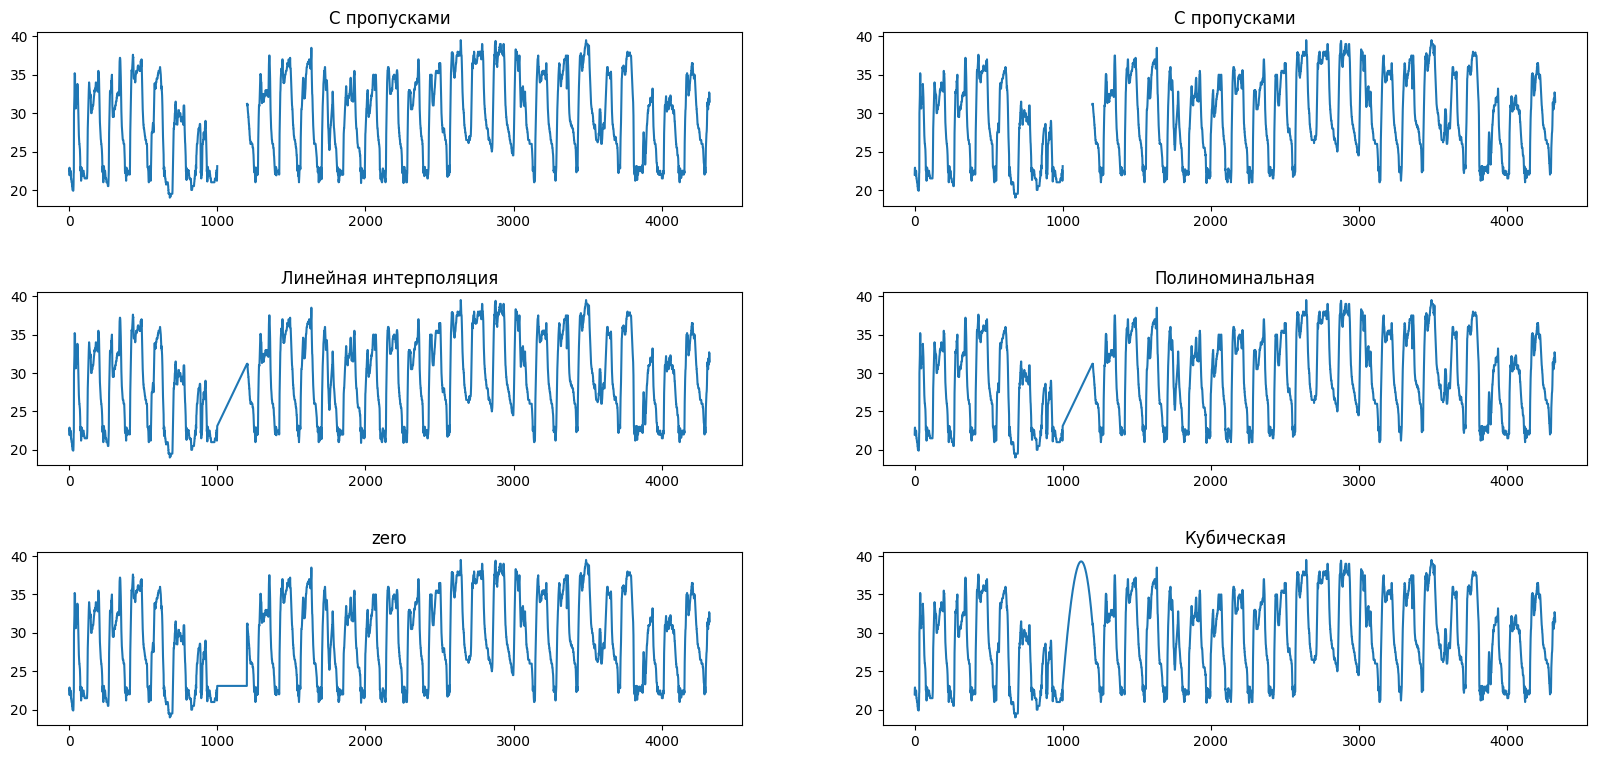

In [62]:
o_df["temperature"][1000:1200] = np.nan

lin_df = o_df.interpolate(method="linear")

cub_df = o_df.interpolate(method="cubic")

pol_df = o_df.interpolate(method="polynomial", order=1) # order = 5 дает необоснованные ответы, а 4 и 10 (больше не проверял, кроме 1, 2 и 3) просто недоступны

zero_df = o_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))
 
o_df["temperature"].plot(title="С пропусками", ax = original_ax)  
o_df["temperature"].plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))  
lin_df["temperature"].plot(title="Линейная интерполяция", ax = lin_ax) 
cub_df["temperature"].plot(title="Кубическая", ax = cub_ax) 
pol_df["temperature"].plot(title="Полиноминальная", ax = pol_ax) 
zero_df["temperature"].plot(title="zero", ax=zero_ax)


### Работа с выбросами

In [63]:
import seaborn as sns

<Axes: >

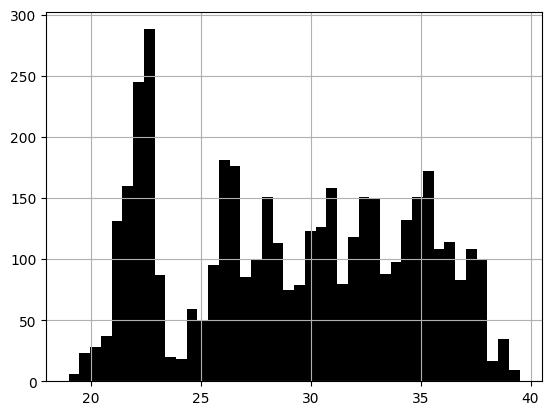

In [70]:
df["temperature"].hist(bins=42, color="black")

Text(0.5, 1.0, 'temperature')

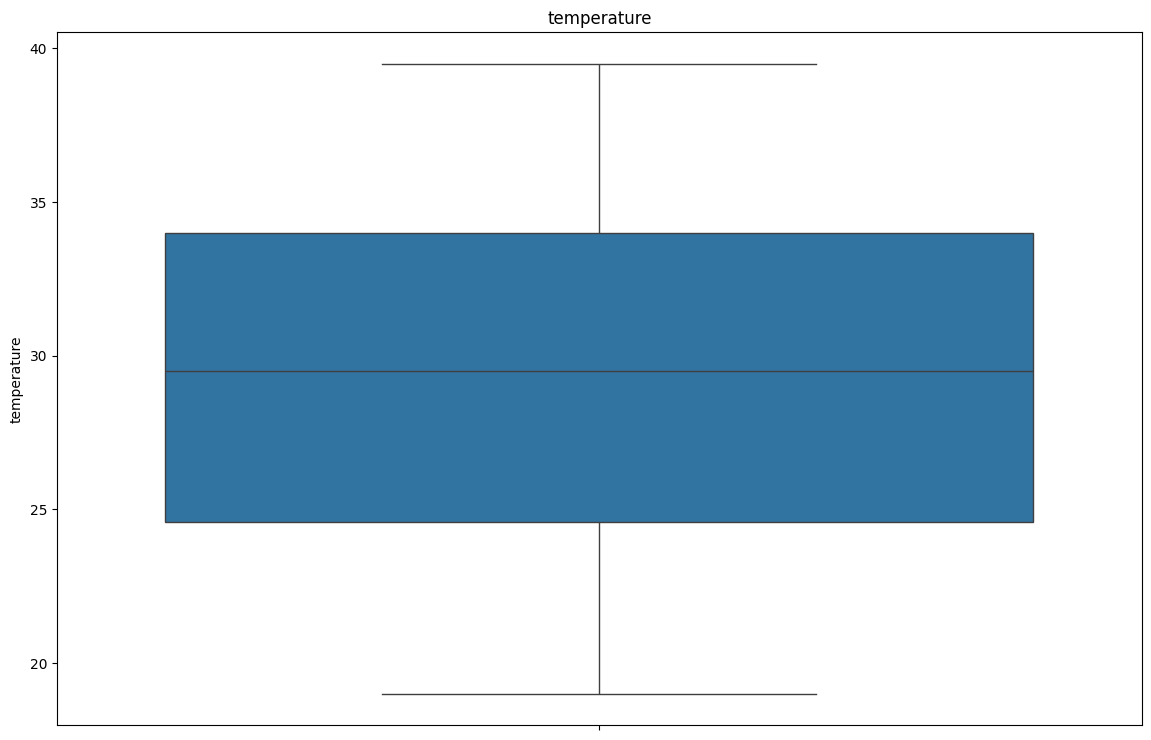

In [71]:
fig = plt.figure(figsize=(14, 9))
 
sns.boxplot(df.temperature).set_title('temperature')

Функцию для автоматического обнаружения выбросов во временном ряду с использованием алгоритма кластеризации из библиотеки scikit-learn: машина векторов поддержки одного класса, она изучает границы распределения (называемые « support ») и, следовательно, может классифицировать любые точки, лежащие за пределами границы, как выбросы.

In [72]:
from sklearn import preprocessing, svm

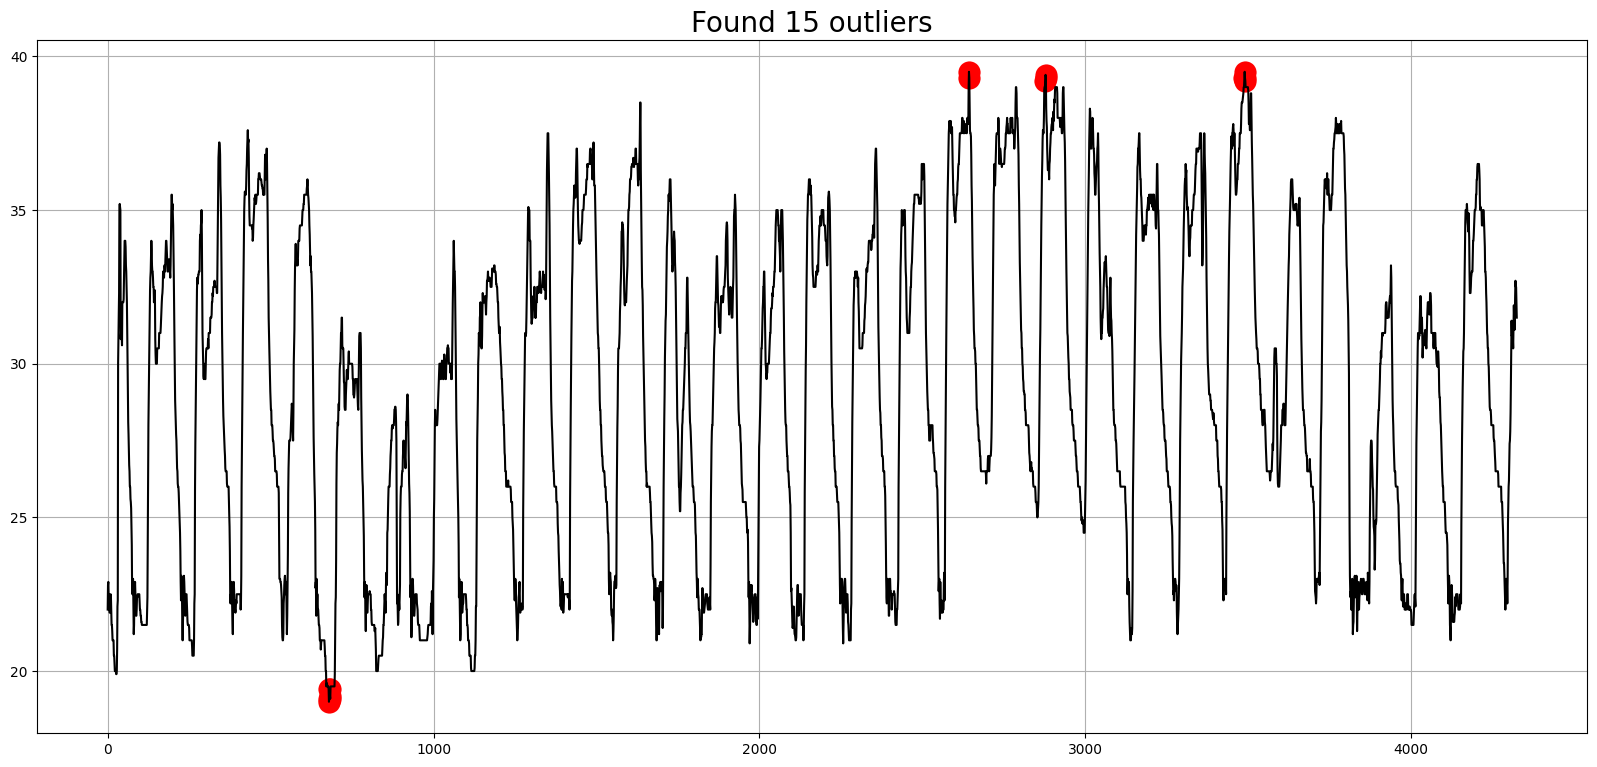

In [73]:
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = df["temperature"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)
## dtf output
dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                                            x: 1 if x==-1 else 0)
## plot
fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

Но что делать с выбросами после обнаружения? Здесь нет оптимальной стратегии: прогнозировать временные ряды проще без точек данных, которые значительно отличаются от других наблюдений, но удаление этих точек может глубоко изменить распределение данных. Если исключить выбросы, наиболее удобный способ их удаления - интерполяция.

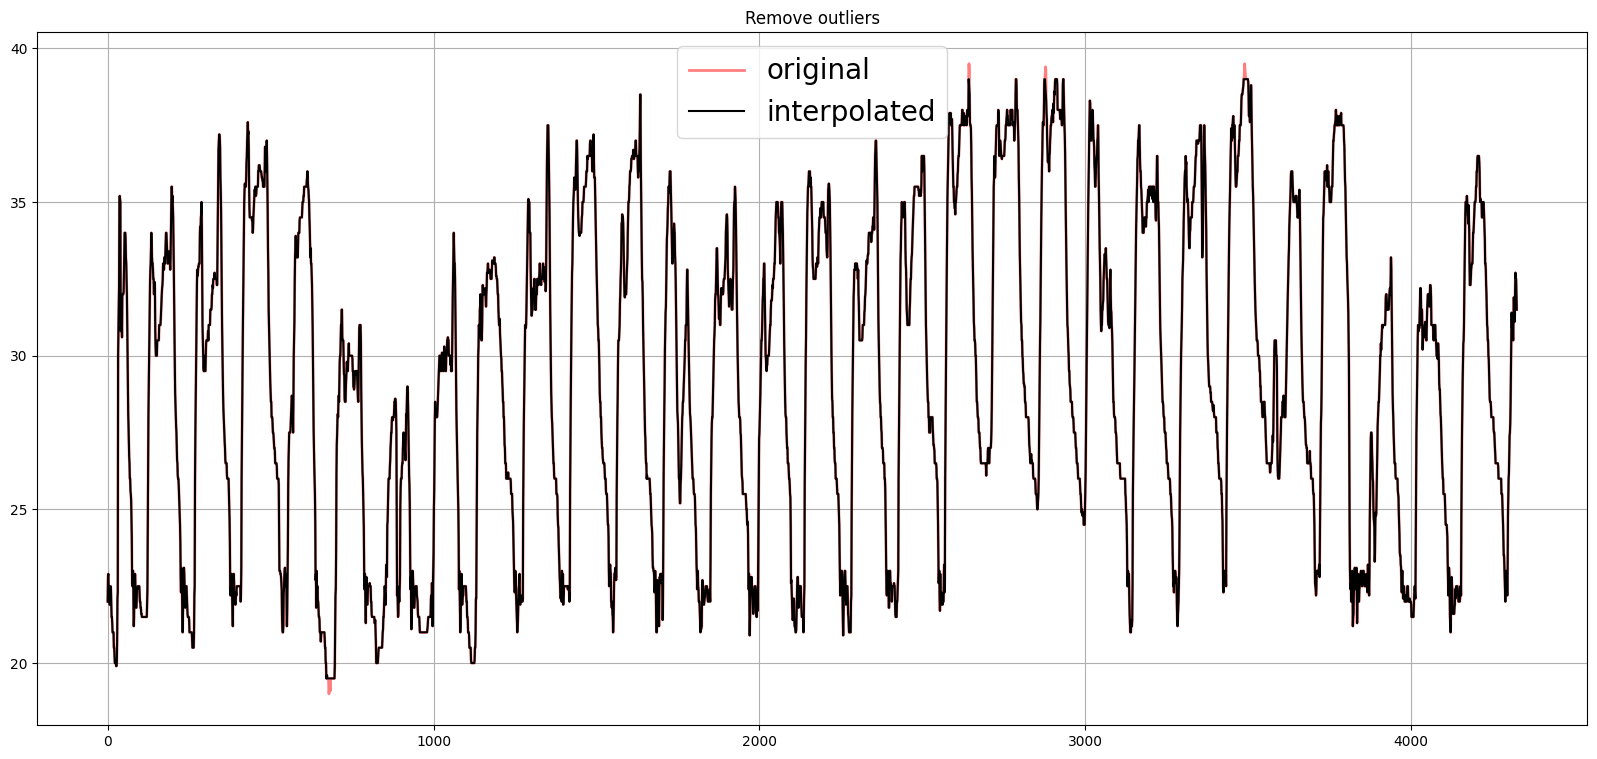

In [74]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()